In [9]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('00_exploration_pm2_5.csv', index_col=0)
df.index=df.index.astype('datetime64[ns]')

In [10]:
df.head()

,pm2_5,dew,temp,press,w_speed,snow,rain,w_dir_ne,w_dir_nw,w_dir_se,w_dir_cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pm2_5     41757 non-null  float64
 1   dew       43800 non-null  int64  
 2   temp      43800 non-null  float64
 3   press     43800 non-null  float64
 4   w_speed   43800 non-null  float64
 5   snow      43800 non-null  int64  
 6   rain      43800 non-null  int64  
 7   w_dir_ne  43800 non-null  int64  
 8   w_dir_nw  43800 non-null  int64  
 9   w_dir_se  43800 non-null  int64  
 10  w_dir_cv  43800 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 4.0 MB


In [12]:
df2=df.dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41757 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pm2_5     41757 non-null  float64
 1   dew       41757 non-null  int64  
 2   temp      41757 non-null  float64
 3   press     41757 non-null  float64
 4   w_speed   41757 non-null  float64
 5   snow      41757 non-null  int64  
 6   rain      41757 non-null  int64  
 7   w_dir_ne  41757 non-null  int64  
 8   w_dir_nw  41757 non-null  int64  
 9   w_dir_se  41757 non-null  int64  
 10  w_dir_cv  41757 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 3.8 MB


In [13]:
yx=df2.to_numpy()

In [14]:
y_train=yx[:,0]
x_train=yx[:,1:]

In [15]:
x_train.shape

(41757, 10)

In [16]:
y_train.shape

(41757,)

# Supervised Learning

In [21]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=6, n_estimators=50,random_state=0)
model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [22]:
import numpy as np
from sklearn.model_selection import cross_val_score
cv=cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
#do not use training set for evaluation

In [23]:
mae=-cv.mean()
mae

54.30396006511633

In [24]:
sigma=cv.std()
sigma

1.8410509719789576

In [25]:
margin=mae + 2.0 * sigma
margin

57.986062009074246

In [26]:
yx_test=df.to_numpy()
x_test=yx_test[:,1:]
y_test=yx_test[:,0]
y_predict=model.predict(x_test)

In [27]:
data=np.concatenate((y_test.reshape(-1,1),y_predict.reshape(-1,1),x_test), axis=1 )

In [28]:
df3=pd.DataFrame(data=data,index=df.index,columns=['y_train','y_prediction']+list(df.columns)[1:])
df3.to_csv('01_basic_prediction.csv',index=True,header=True)

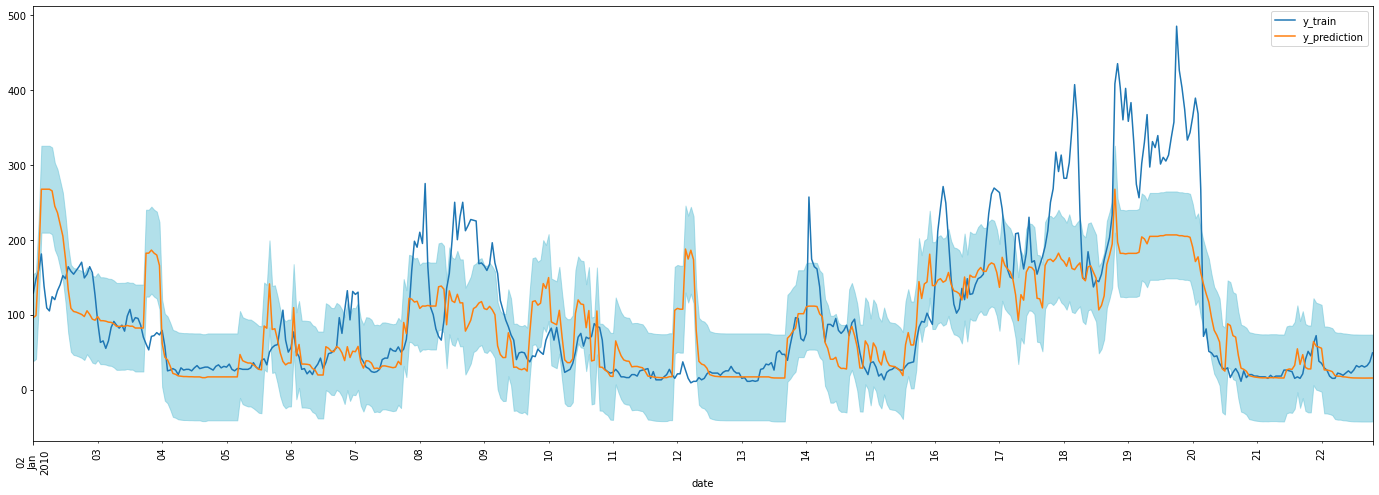

In [29]:
from matplotlib import pyplot as plt
df3.iloc[:500,:2].plot(subplots=False, figsize=(24, 8),rot=90)
fill_alpha = 0.5
fill_color = '#66C2D7'
xticks=df3.iloc[:500,:].index
lower=df3.iloc[:500,1]-margin
upper=df3.iloc[:500,1]+margin
plt.fill_between(xticks, lower, upper, color=fill_color, alpha=fill_alpha, label='95% CI')

In [30]:
import pickle
filename = 'pm2_5.model'
pickle.dump(model, open(filename, 'wb'))

In [31]:
import pickle
filename = 'pm2_5.model'
loaded_model = pickle.load(open(filename, 'rb'))

In [32]:
loaded_model.predict(x_test[:3,:])

array([ 96.10576042,  98.86524721, 168.71990266])

In [33]:
x_test[:3,:]

array([[-1.600e+01, -4.000e+00,  1.020e+03,  1.790e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,  0.000e+00],
       [-1.500e+01, -4.000e+00,  1.020e+03,  2.680e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,  0.000e+00],
       [-1.100e+01, -5.000e+00,  1.021e+03,  3.570e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,  0.000e+00]])